In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from datetime import date
import sqlite3
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels
import statsmodels.graphics.tsaplots as sgt
from scipy.stats import probplot, moment
from scipy import stats
from numpy.random import seed
from numpy import arange
from matplotlib import pyplot
database = sqlite3.connect("Dataset.db")
data = pd.read_sql_query("SELECT * FROM Data", database)
data = data.rename(columns={"('EURUSD Curncy', 'PX_LAST')": "EURUSD","('EURCHF Curncy', 'PX_LAST')": "EURCHF","('EURDKK Curncy', 'PX_LAST')":"EURDKK","('EURGBP Curncy', 'PX_LAST')": "EURGBP","('EURCAD Curncy', 'PX_LAST')": "EURCAD","('EURAUD Curncy', 'PX_LAST')": "EURAUD","('EURJPY Curncy', 'PX_LAST')": "EURJPY","('EURNOK Curncy', 'PX_LAST')": "EURNOK","('EURSEK Curncy', 'PX_LAST')": "EURSEK"})
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
indexed_df = data.set_index('date')
ts_eurusd = indexed_df['EURUSD']
from pylab import rcParams 
import warnings
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 16,8
ts_eurusd = ts_eurusd['2019-01-02':'2022-04-14']
euribor = pd.read_excel("Euribor.xlsx")
euribor = euribor.iloc[:,[0,1]]
euribor['Date'] = pd.to_datetime(euribor['Date'])
indexed_df = euribor.set_index('Date')
ts_euribor = indexed_df["Euribor"]
euribor_2 = pd.read_excel("Euribor_1.xlsx")
euribor_2['Date'] = pd.to_datetime(euribor_2['Unnamed: 0'])
indexed_df = euribor_2.set_index('Date')
ts_euribor_2 = indexed_df["Euribor"]
ts_euribor_2
ts_euribor = pd.concat([ts_euribor, ts_euribor_2]).sort_index()
ts_euribor = ts_euribor.dropna()
ts_euribor = ts_euribor/100
libor = pd.read_csv("LIBORUSD3M_NEW_1.CSV")
libor['Close'] = libor['Close'].str.rstrip("%").astype(float)/100
libor['Date'] = pd.to_datetime(libor['Date'])
indexed_df = libor.set_index('Date')
ts_libor = indexed_df['Close']
libor_2 = pd.read_csv("LIBORUSD3M_NEW_2.CSV")
libor_2['Close'] = libor_2['Close'].str.rstrip("%").astype(float)/100
libor_2['Date'] = pd.to_datetime(libor_2['Date'])
indexed_df = libor_2.set_index('Date')
ts_libor_2 = indexed_df['Close']
libor_3 = pd.read_csv("LIBORUSD3M_NEW_3.CSV")
libor_3['Close'] = libor_3['Close'].str.rstrip("%").astype(float)/100
libor_3['Date'] = pd.to_datetime(libor_3['Date'])
indexed_df = libor_3.set_index('Date')
ts_libor_3 = indexed_df['Close']
libor_4 = pd.read_csv("LIBORUSD3M_NEW_4.CSV")
libor_4['Close'] = libor_4['Close'].str.rstrip("%").astype(float)/100
libor_4['Date'] = pd.to_datetime(libor_4['Date'])
indexed_df = libor_4.set_index('Date')
ts_libor_4 = indexed_df['Close']
s3= pd.concat([ts_libor, ts_libor_2]).sort_index()
s4 = pd.concat([s3, ts_libor_3]).sort_index()
ts_libor = pd.concat([s4, ts_libor_4]).sort_index()
ts_libor = ts_libor.dropna()
fwd_rates = ts_libor.to_frame().join(ts_euribor.to_frame())
fwd_rates = fwd_rates.dropna()
fwd_rates.rename(columns={'Close': 'Libor $'}, inplace=True)
impl_vol = pd.read_csv("VolatilityScanner_DataDeck_AtTheMoneyVols_EURUSD.CSV")
impl_vol['date'] = pd.to_datetime(impl_vol['date'])
indexed_df = impl_vol.set_index('date')
impl_vol['EURUSDV1M Curncy'] = impl_vol['EURUSDV1M Curncy']/100
ts_impl_vol = indexed_df['EURUSDV3M Curncy']
ts_impl_vol = ts_impl_vol/100
ts_impl_vol = ts_impl_vol.dropna()

In [2]:
returns_series = np.log(ts_eurusd).diff().dropna()
ann_volatility_25 = (returns_series.rolling(window = 25).std()*np.sqrt(252)).dropna()
ann_volatility_50 = (returns_series.rolling(window = 50).std()*np.sqrt(252)).dropna()
ann_volatility_100 = (returns_series.rolling(window = 100).std()*np.sqrt(252)).dropna()

In [3]:
def BS_Pricer(S,K,rf,rd,sigma,T,option_type):
    d1 = (np.log(S/K)+(rd-rf+sigma**2/2*T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        price = S * np.exp(-rf * T) * norm.cdf(d1) - K * np.exp(-rd * T) * norm.cdf(d2)
    if option_type == 'put':
        price = K * np.exp(-rd * T) * norm.cdf(-d2) - S * np.exp(-rf * T) * norm.cdf(-d1)
    return (price)

In [4]:
full_data = fwd_rates.join(ts_eurusd.to_frame())
full_data['Implied_Volatility'] = ts_impl_vol
full_data['Historical_Volatility'] = ann_volatility_25
full_data = full_data.dropna()
full_data['Maturity'] = 0.25
full_data['Strike'] = full_data['EURUSD']
full_data

,Libor $,Euribor,EURUSD,Implied_Volatility,Historical_Volatility,Maturity,Strike
Date,,,,,,,
2019-02-07,0.026970,-0.00308,1.1341,0.051000,0.062826,0.25,1.1341
2019-02-08,0.026978,-0.00308,1.1323,0.060400,0.062974,0.25,1.1323
2019-02-12,0.026929,-0.00308,1.1326,0.046850,0.061145,0.25,1.1326
2019-02-13,0.026838,-0.00308,1.1261,0.063600,0.055184,0.25,1.1261
2019-02-14,0.026939,-0.00308,1.1295,0.065500,0.055817,0.25,1.1295
...,...,...,...,...,...,...,...
2022-04-07,0.009889,-0.00465,1.0879,0.093975,0.101487,0.25,1.0879
2022-04-08,0.010107,-0.00449,1.0877,0.100650,0.093590,0.25,1.0877
2022-04-11,0.010214,-0.00435,1.0884,0.108775,0.091021,0.25,1.0884


In [5]:
# Function for analytical Black-Scholes price
def bs_price(S, K, T, rd, rf, sigma, call=True):
    d1 = (np.log(S/K) + (rd - rf + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if call:
        return S * np.exp(-rf*T) * norm.cdf(d1) - K * np.exp(-rd*T)* norm.cdf(d2)
    else:
        return K * np.exp(-rd*T) * norm.cdf(-d2) - S * np.exp(-rf*T) * norm.cdf(-d1)

In [6]:
# Function for analytical Merton jump diffusion price
def merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j , sigma_j, lam, call=True, max_iter=100):
    V = 0
    for k in range(max_iter):
        r_k = rd-rf - lam*(np.exp(mu_j + 0.5*sigma_j**2)-1) + (k*(mu_j + 0.5*sigma_j**2)) / T
        sigma_k = np.sqrt( sigma**2 + (k* sigma_j**2) / T)
        sum_k = (np.exp(-(np.exp(mu_j + 0.5*sigma_j**2))*lam*T) \
                * ((np.exp(mu_j + 0.5*sigma_j**2))*lam*T)**k / (np.math.factorial(k))) \
                * bs_price(S, K, T, r_k, rf ,sigma_k, call)
        V += sum_k
    return V # return the value of the option when the maximum value of k is reached

In [7]:
S = full_data['EURUSD']#Spot price
K = S #Strike Price At-the-Money Option
rf = full_data['Euribor']    # Euribor 3m rate 
rd = full_data['Libor $']    # Dollar Libor 3m rate
sigma = full_data['Historical_Volatility']
T = 0.25 #3-month Maturity

In [8]:
mu_j = 0.01
sigma_j = 0.03
lam = 1 # intensity of jump i.e. number of jumps per annum

In [9]:
# Call value
Vc = merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j, sigma_j, lam, call=True, max_iter=50)

# Put value
Vp = merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j, sigma_j, lam, call=False, max_iter=50)

print('Call price: ' + str(round(Vc, 7)))
print('Put price:  ' + str(round(Vp, 7)))

Call price: Date
2019-02-07    0.020693
2019-02-08    0.020691
2019-02-12    0.020314
2019-02-13    0.018978
2019-02-14    0.019180
                ...   
2022-04-07    0.025659
2022-04-08    0.024000
2022-04-11    0.023458
2022-04-13    0.020563
2022-04-14    0.020027
Length: 714, dtype: float64
Put price:  Date
2019-02-07    0.011331
2019-02-08    0.011343
2019-02-12    0.010977
2019-02-13    0.009720
2019-02-14    0.009865
                ...   
2022-04-07    0.020447
2022-04-08    0.018816
2022-04-11    0.018318
2022-04-13    0.015289
2022-04-14    0.014710
Length: 714, dtype: float64


In [10]:
BS_Pricer(S,K,rf,rd,sigma,T,'call')

Date
2019-02-07    0.016023
2019-02-08    0.016033
2019-02-12    0.015597
2019-02-13    0.014095
2019-02-14    0.014290
                ...   
2022-04-07    0.023543
2022-04-08    0.021795
2022-04-11    0.021236
2022-04-13    0.018042
2022-04-14    0.017447
Length: 714, dtype: float64

In [11]:
BS_Pricer(S,K,rf,rd,sigma,T,'put')

Date
2019-02-07    0.007528
2019-02-08    0.007550
2019-02-12    0.007125
2019-02-13    0.005697
2019-02-14    0.005839
                ...   
2022-04-07    0.019591
2022-04-08    0.017829
2022-04-11    0.017276
2022-04-13    0.013983
2022-04-14    0.013350
Length: 714, dtype: float64

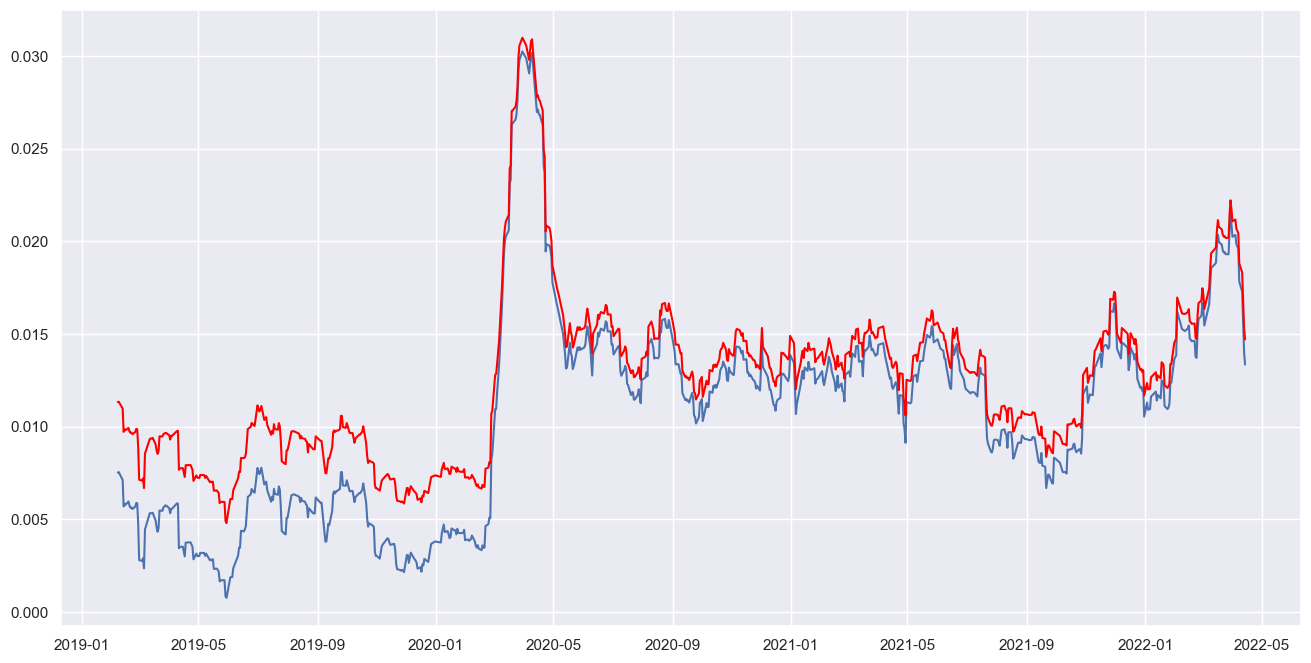

In [12]:
plt.plot(BS_Pricer(S,K,rf,rd,sigma,T,'put'))
plt.plot(Vp,color = 'red')

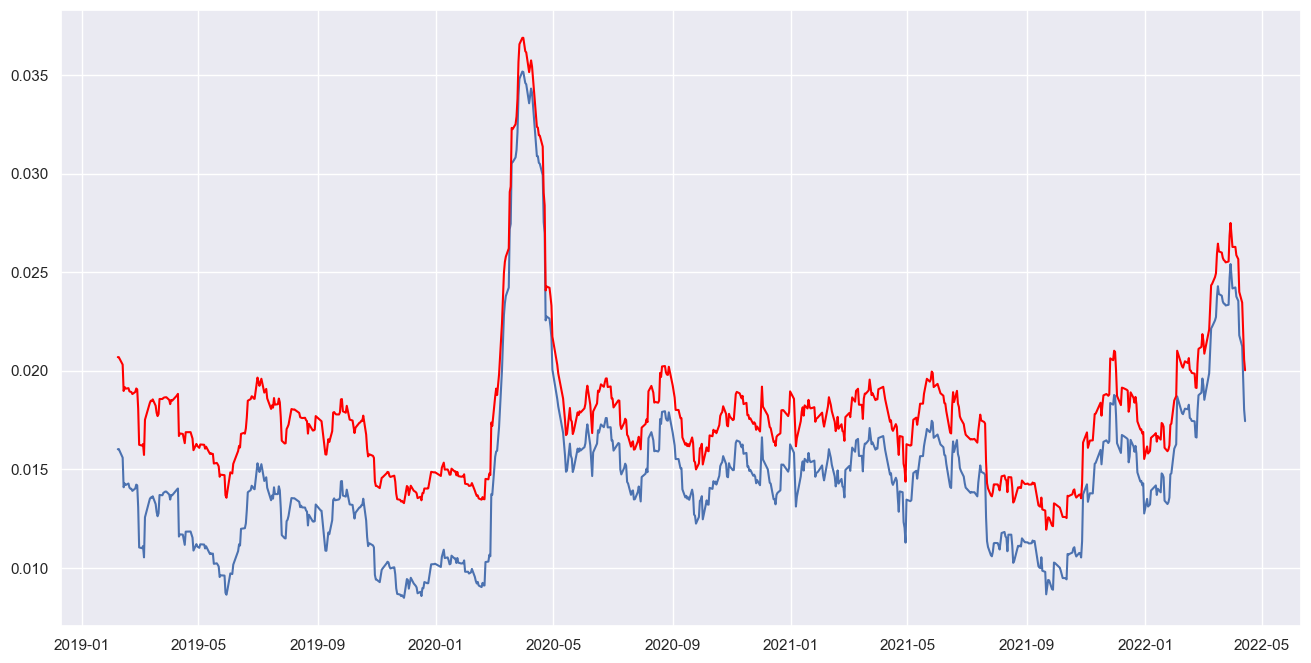

In [13]:
plt.plot(BS_Pricer(S,K,rf,rd,sigma,T,'call'))
plt.plot(Vc,color = 'red')

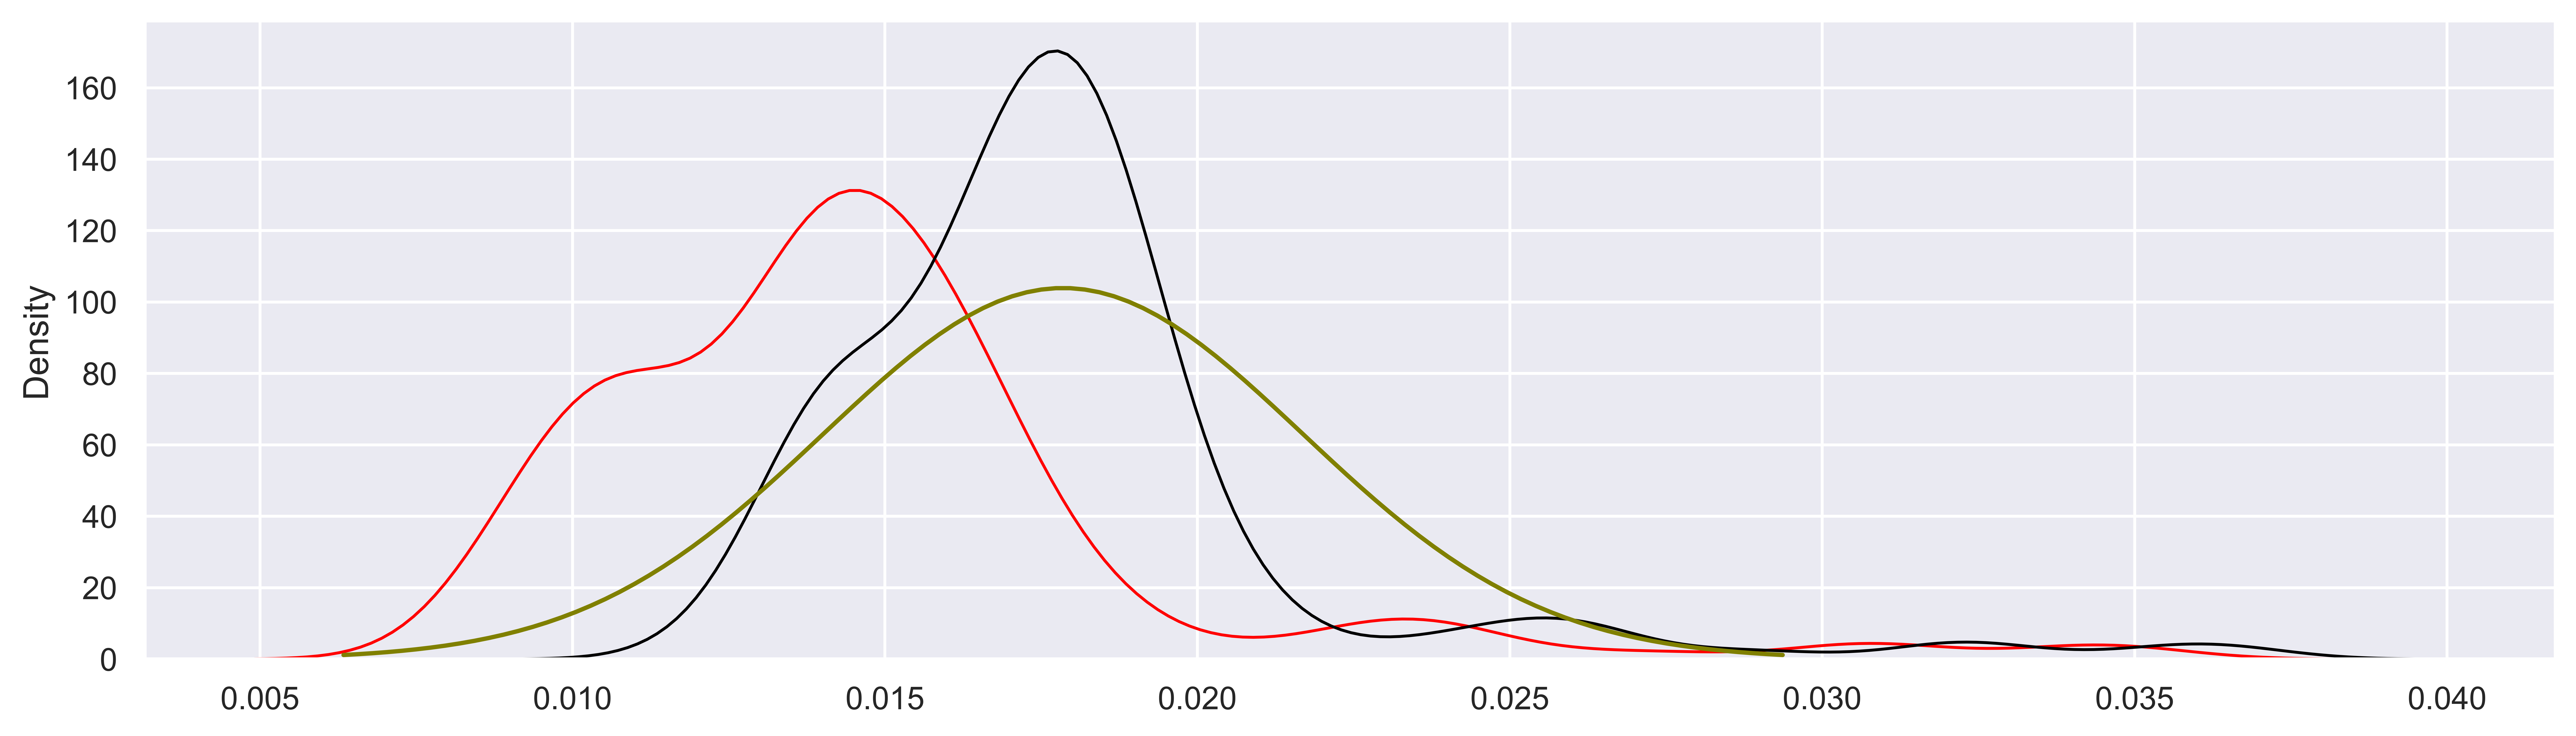

In [14]:
plt.figure(dpi = 1000, figsize=(15, 4))
sns.distplot(BS_Pricer(S,K,rf,rd,sigma,T,'call'), hist=False, kde=True, bins=int(180/5), color = 'red',kde_kws={'linewidth': 1})
sns.distplot(Vc, hist=False, kde=True, bins=int(180/5), color = 'black',kde_kws={'linewidth': 1})
x = np.linspace(np.mean(Vc) - 3*np.std(Vc), np.mean(Vc) +
3*np.std(Vc), 100)
plt.plot(x, norm.pdf(x, np.mean(Vc), np.std(Vc)), color = 'olive')

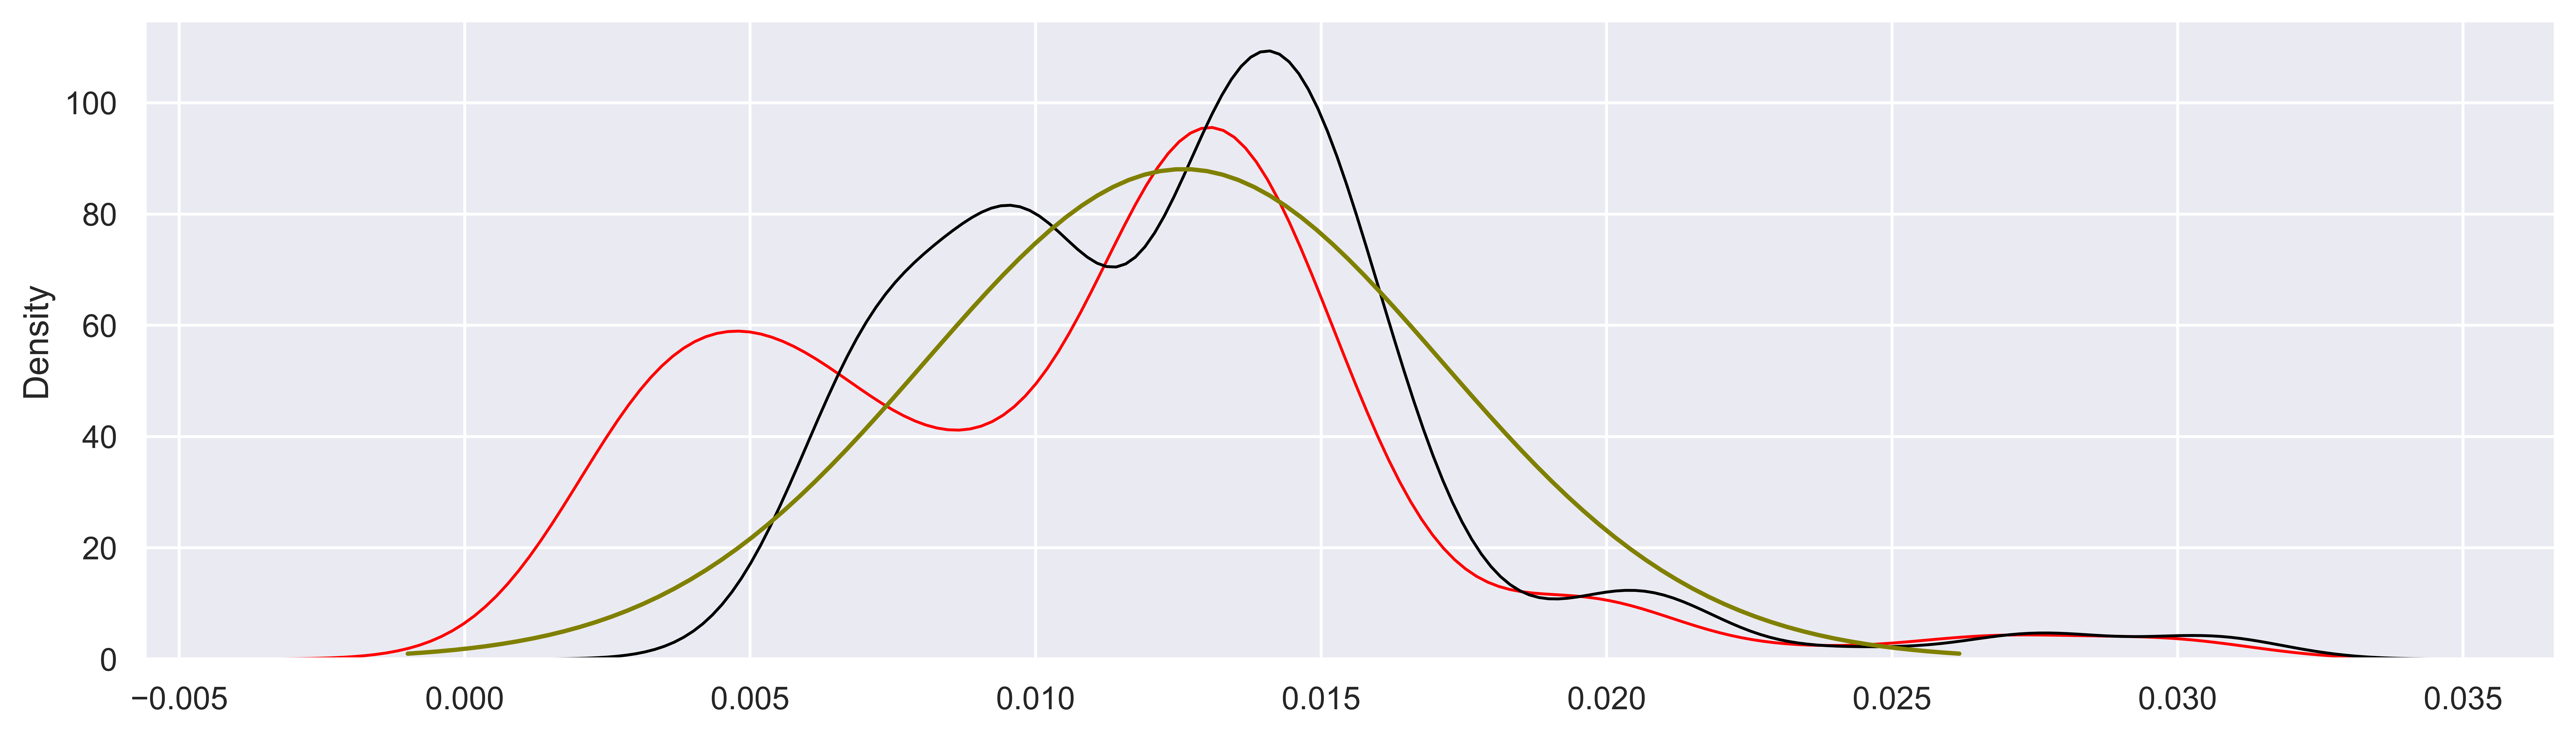

In [15]:
plt.figure(dpi = 1000, figsize=(15, 4))
sns.distplot(BS_Pricer(S,K,rf,rd,sigma,T,'put'), hist=False, kde=True, bins=int(180/5), color = 'red',kde_kws={'linewidth': 1})
sns.distplot(Vp, hist=False, kde=True, bins=int(180/5), color = 'black',kde_kws={'linewidth': 1})
x = np.linspace(np.mean(Vp) - 3*np.std(Vp), np.mean(Vp) +
3*np.std(Vp), 100)
plt.plot(x, norm.pdf(x, np.mean(Vp), np.std(Vp)), color = 'olive')

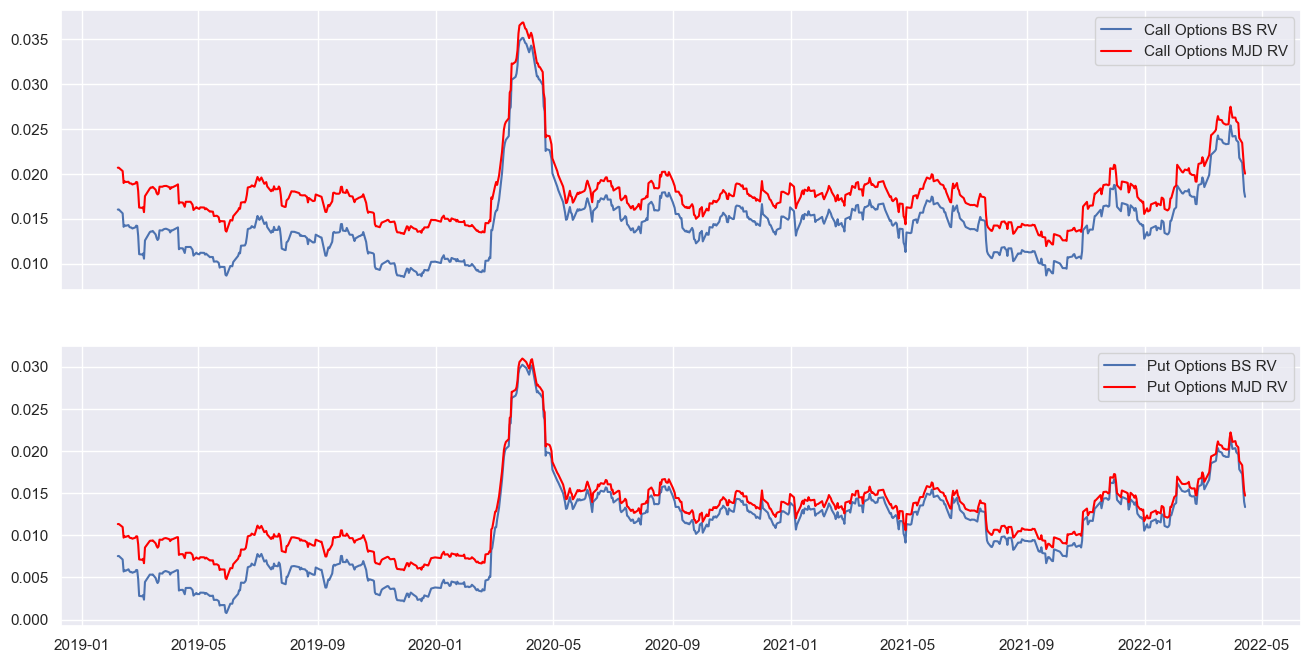

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(BS_Pricer(S,K,rf,rd,sigma,T,'call'))
ax1.plot(Vc,color = 'red')
ax1.legend(['Call Options BS RV', 'Call Options MJD RV'])

ax2.plot(BS_Pricer(S,K,rf,rd,sigma,T,'put'))
ax2.plot(Vp,color = 'red')
ax2.legend(['Put Options BS RV', 'Put Options MJD RV'])

plt.show()

In [17]:
S = full_data['EURUSD']#Spot price
K = S #Strike Price At-the-Money Option
rf = full_data['Euribor']    # Euribor 3m rate 
rd = full_data['Libor $']    # Dollar Libor 3m rate
sigma = full_data['Implied_Volatility']
T = 0.25 #3-month Maturity

In [18]:
# Call value
Vc = merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j, sigma_j, lam, call=True, max_iter=50)

# Put value
Vp = merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j, sigma_j, lam, call=False, max_iter=50)

print('Call price: ' + str(round(Vc, 7)))
print('Put price:  ' + str(round(Vp, 7)))

Call price: Date
2019-02-07    0.018294
2019-02-08    0.020165
2019-02-12    0.017439
2019-02-13    0.020683
2019-02-14    0.021152
                ...   
2022-04-07    0.024100
2022-04-08    0.025465
2022-04-11    0.027151
2022-04-13    0.020252
2022-04-14    0.020209
Length: 714, dtype: float64
Put price:  Date
2019-02-07    0.008932
2019-02-08    0.010816
2019-02-12    0.008101
2019-02-13    0.011425
2019-02-14    0.011837
                ...   
2022-04-07    0.018887
2022-04-08    0.020281
2022-04-11    0.022011
2022-04-13    0.014977
2022-04-14    0.014892
Length: 714, dtype: float64


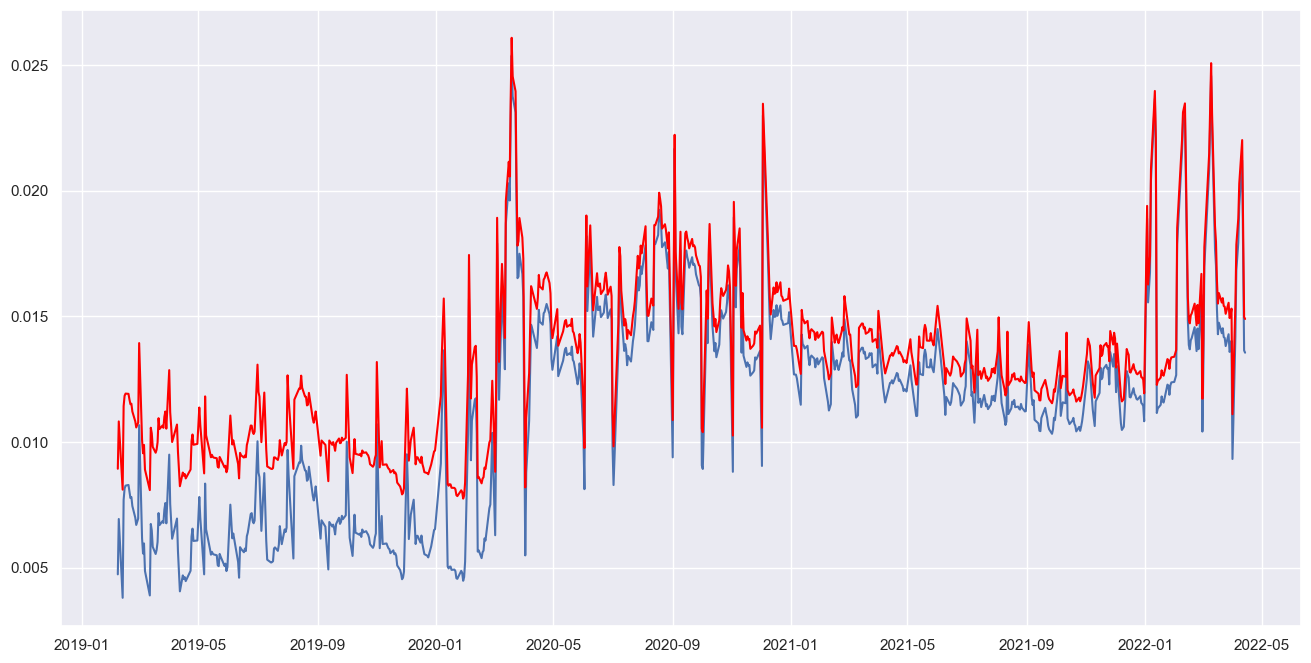

In [19]:
plt.plot(BS_Pricer(S,K,rf,rd,sigma,T,'put'))
plt.plot(Vp,color = 'red')

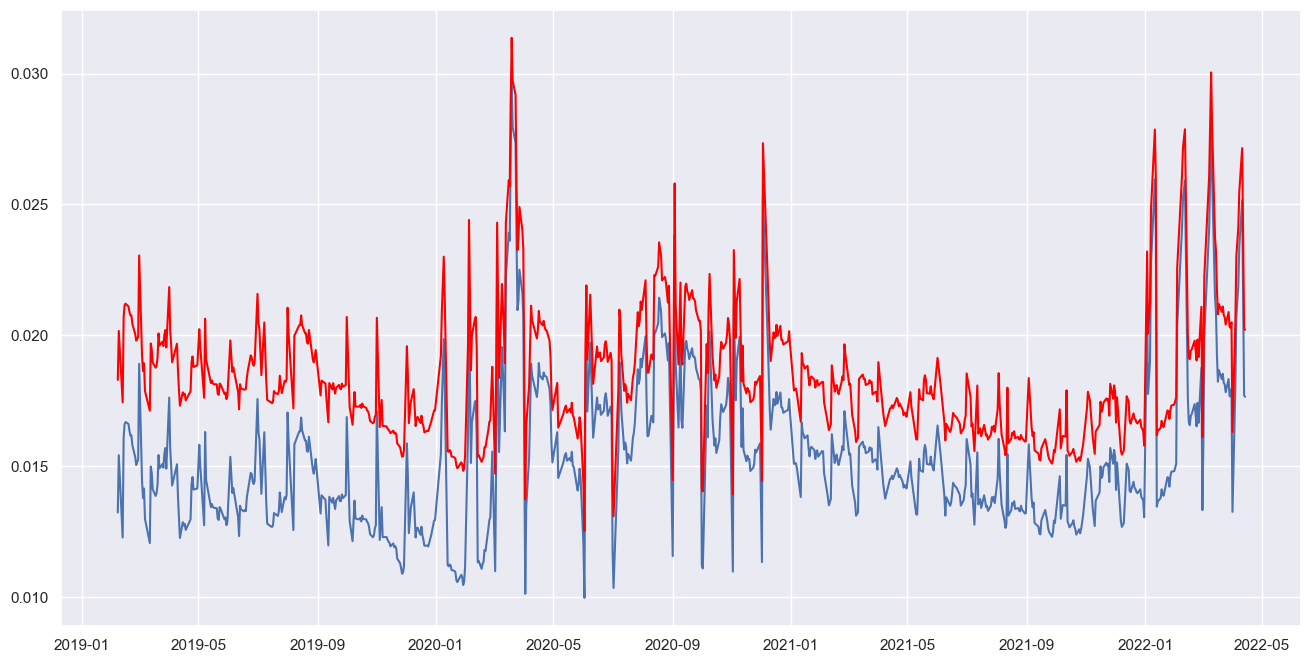

In [20]:
plt.plot(BS_Pricer(S,K,rf,rd,sigma,T,'call'))
plt.plot(Vc,color = 'red')

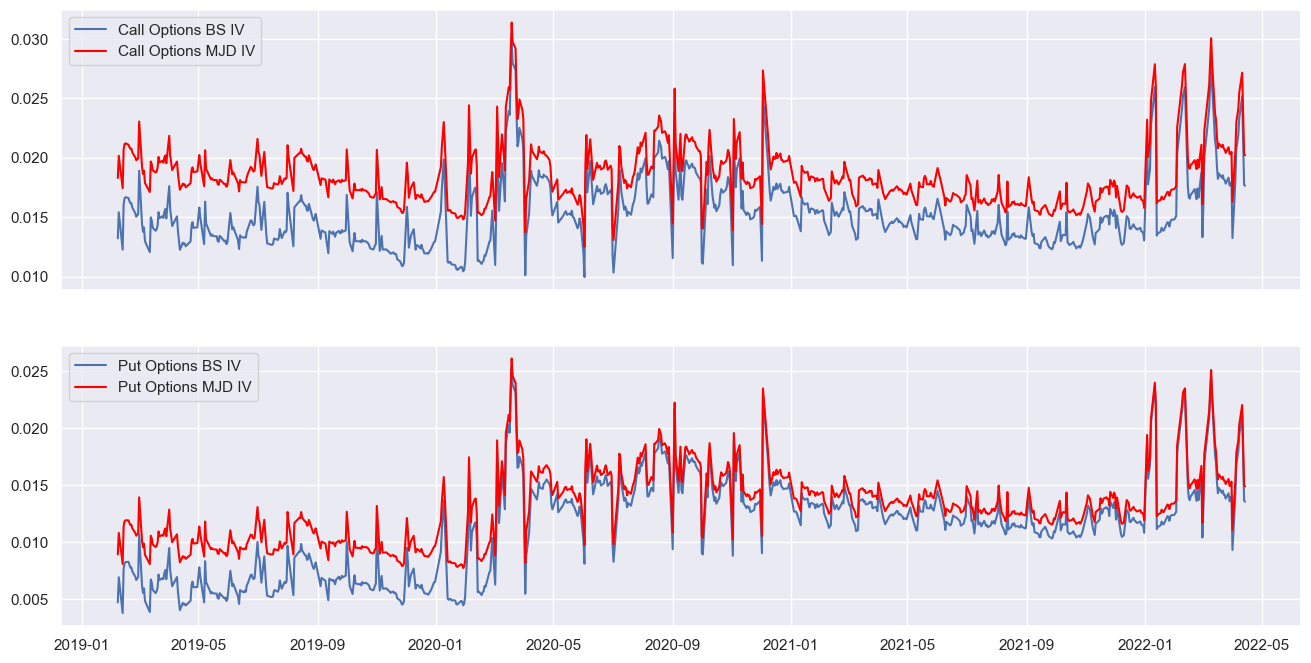

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(BS_Pricer(S,K,rf,rd,sigma,T,'call'))
ax1.plot(Vc,color = 'red')
ax1.legend(['Call Options BS IV', 'Call Options MJD IV'])

ax2.plot(BS_Pricer(S,K,rf,rd,sigma,T,'put'))
ax2.plot(Vp,color = 'red')
ax2.legend(['Put Options BS IV', 'Put Options MJD IV'])

plt.show()

In [22]:
mu_j = 0.03
sigma_j = 0.06
lam = 1.5 # intensity of jump i.e. number of jumps per annum
S = full_data['EURUSD']#Spot price
K = S #Strike Price At-the-Money Option
rf = full_data['Euribor']    # Euribor 3m rate 
rd = full_data['Libor $']    # Dollar Libor 3m rate
sigma = full_data['Historical_Volatility']
T = 0.25 #3-month Maturity

In [23]:
# Call value
Vc = merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j, sigma_j, lam, call=True, max_iter=50)

# Put value
Vp = merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j, sigma_j, lam, call=False, max_iter=50)

print('Call price: ' + str(round(Vc, 7)))
print('Put price:  ' + str(round(Vp, 7)))

Call price: Date
2019-02-07    0.025959
2019-02-08    0.025946
2019-02-12    0.025615
2019-02-13    0.024394
2019-02-14    0.024594
                ...   
2022-04-07    0.029993
2022-04-08    0.028511
2022-04-11    0.028033
2022-04-13    0.025493
2022-04-14    0.024985
Length: 714, dtype: float64
Put price:  Date
2019-02-07    0.016598
2019-02-08    0.016597
2019-02-12    0.016277
2019-02-13    0.015135
2019-02-14    0.015279
                ...   
2022-04-07    0.024780
2022-04-08    0.023327
2022-04-11    0.022893
2022-04-13    0.020219
2022-04-14    0.019668
Length: 714, dtype: float64


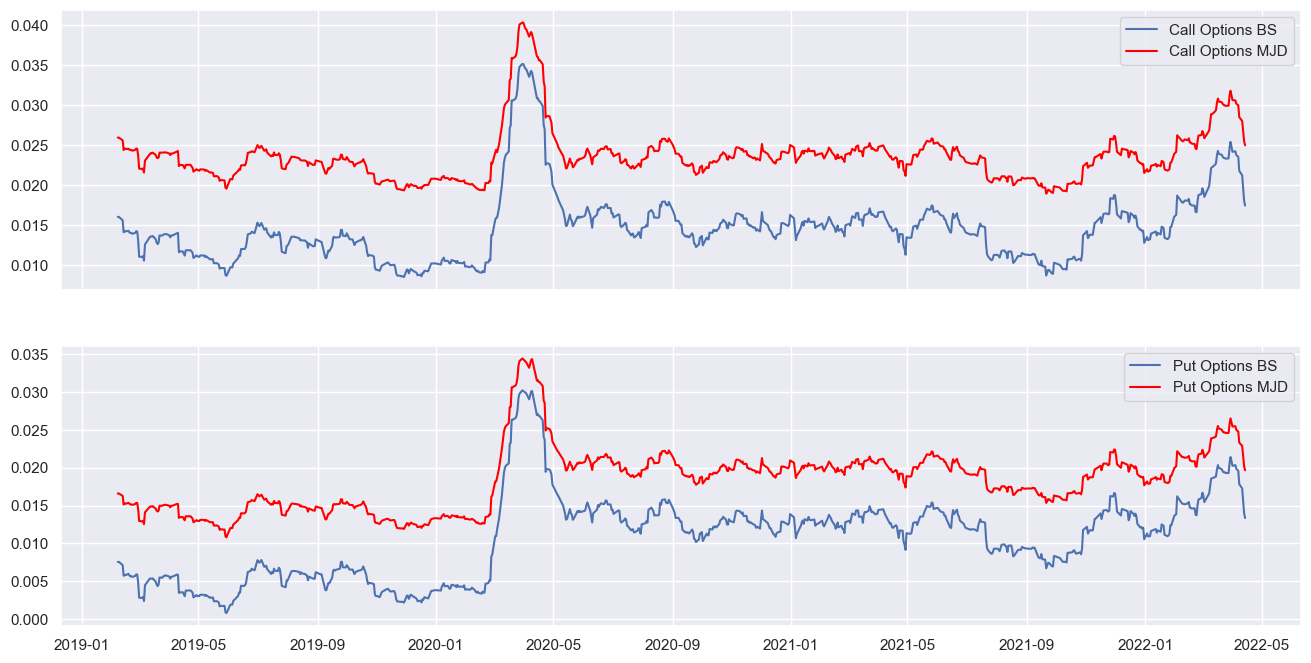

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(BS_Pricer(S,K,rf,rd,sigma,T,'call'))
ax1.plot(Vc,color = 'red')
ax1.legend(['Call Options BS', 'Call Options MJD'])

ax2.plot(BS_Pricer(S,K,rf,rd,sigma,T,'put'))
ax2.plot(Vp,color = 'red')
ax2.legend(['Put Options BS', 'Put Options MJD'])

plt.show()

In [25]:
mu_j = 0.1
sigma_j = 0.15
lam = 0.5 # intensity of jump i.e. number of jumps per annum
S = full_data['EURUSD']#Spot price
K = S #Strike Price At-the-Money Option
rf = full_data['Euribor']    # Euribor 3m rate 
rd = full_data['Libor $']    # Dollar Libor 3m rate
sigma = full_data['Historical_Volatility']
T = 0.25 #3-month Maturity

In [26]:
# Call value
Vc = merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j, sigma_j, lam, call=True, max_iter=50)

# Put value
Vp = merton_jump_analytical(S, K, T, rd, rf, sigma, mu_j, sigma_j, lam, call=False, max_iter=50)

print('Call price: ' + str(round(Vc, 7)))
print('Put price:  ' + str(round(Vp, 7)))

Call price: Date
2019-02-07    0.028306
2019-02-08    0.028291
2019-02-12    0.027932
2019-02-13    0.026596
2019-02-14    0.026812
                ...   
2022-04-07    0.032868
2022-04-08    0.031329
2022-04-11    0.030835
2022-04-13    0.028151
2022-04-14    0.027599
Length: 714, dtype: float64
Put price:  Date
2019-02-07    0.018944
2019-02-08    0.018943
2019-02-12    0.018594
2019-02-13    0.017337
2019-02-14    0.017497
                ...   
2022-04-07    0.027655
2022-04-08    0.026145
2022-04-11    0.025695
2022-04-13    0.022876
2022-04-14    0.022282
Length: 714, dtype: float64


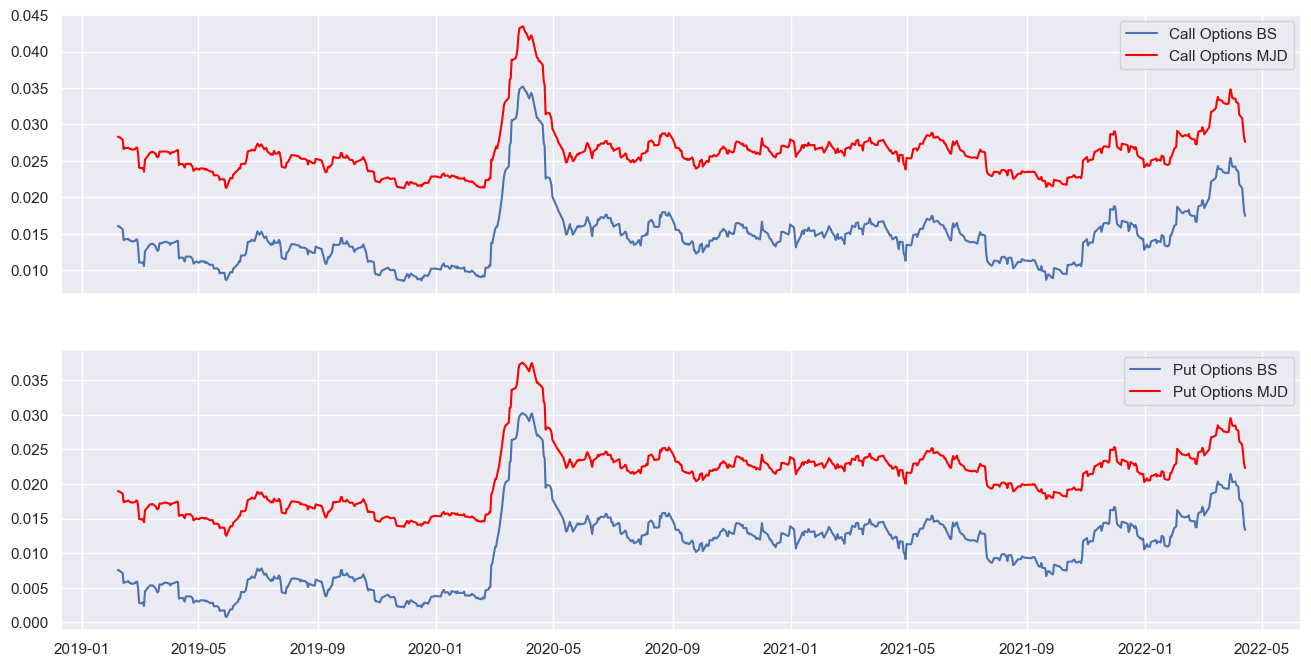

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(BS_Pricer(S,K,rf,rd,sigma,T,'call'))
ax1.plot(Vc,color = 'red')
ax1.legend(['Call Options BS', 'Call Options MJD'])

ax2.plot(BS_Pricer(S,K,rf,rd,sigma,T,'put'))
ax2.plot(Vp,color = 'red')
ax2.legend(['Put Options BS', 'Put Options MJD'])

plt.show()